In [1]:
import jax.numpy as jnp
from matplotlib import pyplot as plt
from ang_pow import *
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ

In [2]:
z = jnp.linspace(1e-4, 2.5, 100)
n_bins = 5
omega_b = 0.02242
omega_cdm = 0.11933
h = 0.6766
ns = 0.9665
ln_As = 3.047
cosmo_params = jnp.array([omega_b, omega_cdm, h, ns, ln_As])
c_min = 2.6
eta_0 = 0.7
m_bias = jnp.zeros(5)
galaxy_bias = jnp.ones(5)
ell = jnp.logspace(jnp.log10(100.0), jnp.log10(1000.0), num=5)
delta_z = jnp.zeros(5)
delta_z_lens, delta_z_source = delta_z, delta_z
fsky = 0.3
sigma_eps_sq = 0.26
n_eff = 30.
emulator = CPJ(probe='mpk_nonlin')

In [3]:
# build the n(z)
nz = compute_nz_bins(z, n_bins)


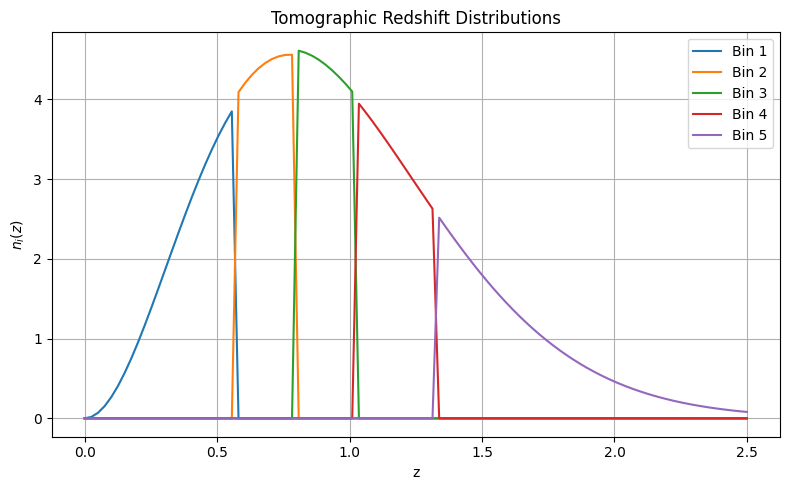

In [4]:
# plot the nz
# Compute tomographic n(z)
nz = compute_nz_bins(z, n_bins)

# Plot
plt.figure(figsize=(8, 5))
for i in range(n_bins):
    plt.plot(z, nz[i], label=f'Bin {i+1}')
plt.xlabel('z')
plt.ylabel(r'$n_i(z)$')
plt.title('Tomographic Redshift Distributions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
#compute the power spectra
k, p_k = compute_nonlinear_pk(z, cosmo_params, c_min, eta_0, emulator)

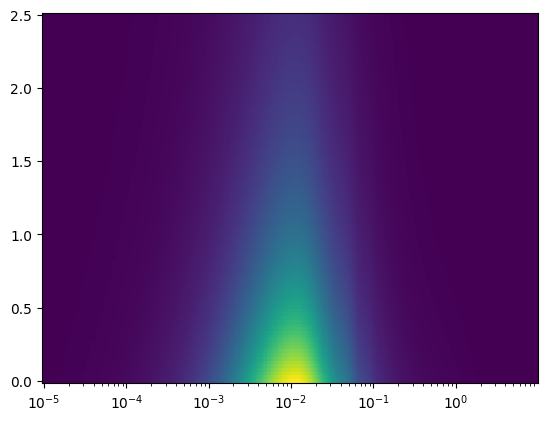

In [6]:
# plot the power spectra
plt.pcolormesh(k,z , p_k)
plt.xscale('log')
#plt.yscale('log')

In [7]:
cl_gg_all, cl_gk_all, cl_kk_all = compute_3x2pt_cls(nz, nz, z, k, p_k, ell,
                      delta_z_lens, delta_z_source, m_bias, galaxy_bias,
                      h, omega_b, omega_cdm)

In [8]:
d = flatten_cls_to_vector_jax_safe(cl_gg_all, cl_gk_all, cl_kk_all)

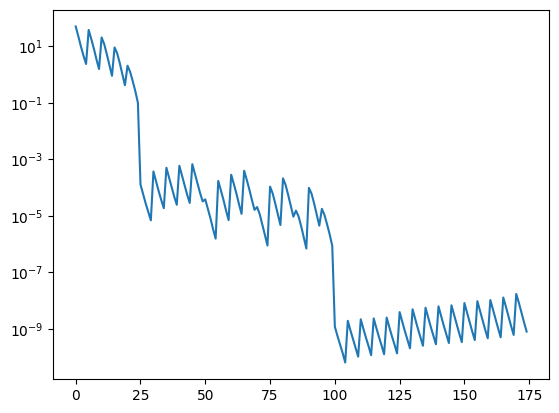

In [9]:
plt.plot(d)
plt.yscale('log')

In [10]:
cov = compute_gaussian_covariance_matrix(
    cl_gg_all, cl_gk_all, cl_kk_all, ell, n_eff, sigma_eps_sq, fsky
)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.0000001 0.        ... 0.        0.        0.       ]
 [0.        0.        1.0000001 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        0.       ]
 [0.        0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.9999999]]


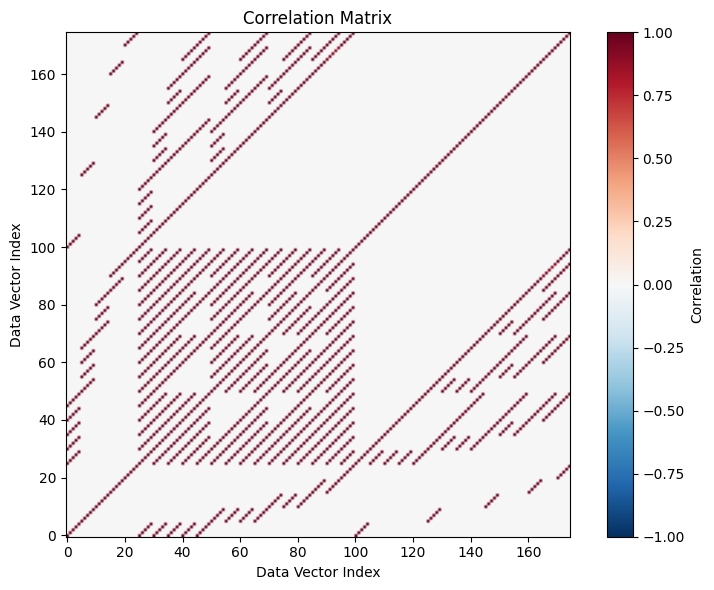

In [11]:
def plot_correlation_matrix(cov, title="Correlation Matrix"):
    # Compute correlation matrix
    diag = jnp.sqrt(jnp.diag(cov))
    corr = cov / jnp.outer(diag, diag)

    print (corr)
    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
    plt.colorbar(im, label='Correlation')
    plt.title(title)
    plt.xlabel('Data Vector Index')
    plt.ylabel('Data Vector Index')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(cov)

In [12]:
diag = jnp.sqrt(jnp.diag(cov))
corr = cov / jnp.outer(diag, diag)
corr

Array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0000001, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.0000001, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.9999999]], dtype=float32)

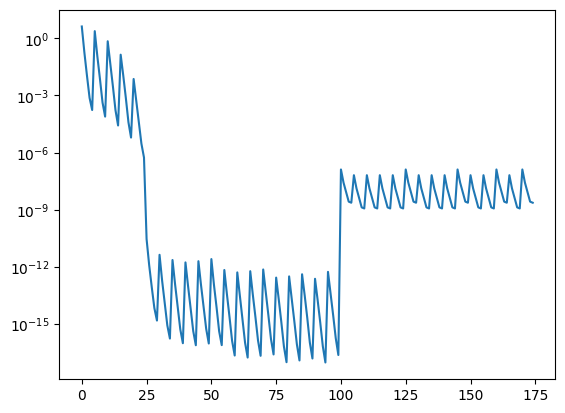

In [13]:
plt.plot(cov.diagonal())
plt.yscale('log')

In [14]:
cov_inv = np.linalg.inv(cov)
gaussian_loglike(
    nz, nz, z, k, p_k, ell,
    delta_z, delta_z, m_bias, galaxy_bias,
    h, omega_b, omega_cdm,
    cov_inv, d
)

Array(-0., dtype=float32)

In [17]:
# now lets pass to the wrapper
b = 1.
dz = 0.
m = 0.
theta = jnp.array([omega_b, omega_cdm, h, ns, ln_As, c_min, eta_0, b, b, b, b, b, dz, dz, dz, dz, dz, m, m, m, m, m]) 
loglike_jax_wrapper(
    theta,  # 1D jnp.ndarray
    n_bins,  # shared for lens/source
    z, k, p_k,
    ell, cov, d
)

NameError: name 'loglike_jax_wrapper' is not defined